In [1]:
import numpy as np
import pandas as pd
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import os
import math
from skimage import color
import scipy
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import numpy.linalg as LA
import warnings
warnings.filterwarnings("ignore")
# Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in np.arange(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)

In [2]:
def oc(s,ig,si,k):
    octave1=[]
    for i in range(s+3):  #0-5
        ga=k**i*si;
        #kernelsize = int(2*np.ceil(3*ga)+1)
        octave1.append(gaussian_filter(ig, ga))
        #octave1.append(cv2.GaussianBlur(ig,(kernelsize,kernelsize),ga))
    return(octave1)

def dog(octave1,s):  
    d=[]
    for i in range(s+2):  #0-4
        d.append(octave1[i+1]-octave1[i])
    return(d)    

In [35]:
#extrema
def extremakey(octave,s,DoG,window):  #window*window*3
    key1=[]
    for octa in range(octave):
        for i in range(1,s+1): #1-3
            shap=DoG[octa][i].shape
            for j in range(10,shap[0]-10):
                for m in range(10,shap[1]-10):
                    window1=window//2
                    www=np.concatenate((DoG[octa][i-1][j-window1:j+window1+1,m-window1:m+window1+1], 
                                        DoG[octa][i][j-window1:j+window1+1,m-window1:m+window1+1],
                                        DoG[octa][i+1][j-window1:j+window1+1,m-window1:m+window1+1]))
                    arg=window**2+np.ceil((window**2)/2)
                    if (np.argmin(www)==arg or np.argmax(www)==arg):
                        key1.append(np.array([[m,j],[i,octa]])) #j=y,m=x
    return(key1)

In [4]:
def finitediff(DoG,key,k,si): #i=s 
    octa=key[1][1]
    x=key[0][0]
    y=key[0][1]
    i=key[1][0]
    dx = (DoG[octa][i][y,x+1]-DoG[octa][i][y,x-1])/2.
    dy = (DoG[octa][i][y+1,x]-DoG[octa][i][y-1,x])/2.
    di = (DoG[octa][i+1][y,x]-DoG[octa][i-1][y,x])/2.

    dxx = DoG[octa][i][y,x+1]-2*DoG[octa][i][y,x]+DoG[octa][i][y,x-1]
    dxy = ((DoG[octa][i][y+1,x+1]-DoG[octa][i][y+1,x-1]) - (DoG[octa][i][y+1,x-1]-DoG[octa][i][y-1,x-1]))/4
    dxi = ((DoG[octa][i+1][y,x+1]-DoG[octa][i+1][y,x-1]) - (DoG[octa][i-1][y,x+1]-DoG[octa][i-1][y,x-1]))/4
    dyy = DoG[octa][i][y+1,x]-2*DoG[octa][i][y,x]+DoG[octa][i][y-1,x]
    #print('yy:',DoG[octa][i][y+1,x],DoG[octa][i][y,x],DoG[octa][i][y-1,x])
    dyi = ((DoG[octa][i+1][y+1,x]-DoG[octa][i+1][y-1,x]) - (DoG[octa][i-1][y+1,x]-DoG[octa][i-1][y-1,x]))/4
    dii = DoG[octa][i+1][y,x]-2*DoG[octa][i][y,x]+DoG[octa][i-1][y,x]
    #print('ii:',DoG[octa][i+1][y,x],DoG[octa][i][y,x],DoG[octa][i-1][y,x])
    if dii==0:
        dii=0.00001
    if dxx==0:
        dxx=0.00001
    if dyy==0:
        dyy=0.00001
    if dxy==0:
        dxy=0.00001
    if dxi==0:
        dxi=0.00001
    if dyi==0:
        dyi=0.00001
    J = np.array([dx, dy, di])
    HD = np.array([[dxx, dxy, dxi],
                   [dxy, dyy, dyi],
                    [dxi, dyi, dii]])
    #print(HD)
    #print('till here safe')
    try:
        offset = -LA.inv(HD).dot(J)
        return offset, J, HD[:2,:2], x, y, i
    except:
        pass
        return J
        

In [634]:
def findkey(DoG,octave,si,k,s,R_th=10,window=5): #r=10 #octave:total octave
    key1=extremakey(octave,s,DoG,window)
    keypoint=[]
    DD=DoG[0][0]
    #extrem_list=[]
    for key in key1:
        try:
            offset, J, H, x, y, i=finitediff(DoG,key,k,si)
            sigma=si*(k**i)*(2**(key[1,1]))
            if min(abs(offset))>0.5:
                continue
            D=DoG[key[1,1]][key[1,0]]
            extrem=D[y,x]+0.5*J.dot(offset) 


            if abs(extrem)>0.03: 
                #ei=((H[0,0]+H[1,1])**2)/(H[0,0]*H[1,1]-(H[1,0])**2)
                w, v = LA.eig(H)
                r = w[0]/w[1]
                R = (r+1)**2 / r
                if R<((R_th+1)**2/R_th):
                    kk=np.array([x,y,sigma])
                    keypoint.append([kk[0:2],kk[2],key[1,0],key[1,1]])
                    #print(keypoint)
                    #extrem_list.append(abs(extrem))
                else:continue
            else:continue
        
        except: pass
    '''for number in range(10,int(max(extrem_list)),10):
        select = [1 if x >number else 0 for x in extrem_list]
        if sum(select)<2000:
            break
    select_keypoint = np.array([d for d, s in zip(keypoint, select) if s == 1])'''
    return(keypoint)
            


In [6]:
def cart(dGx, dGy): #dGx=L(x+1,y)-L(x-1,y)
    '''m1 = np.sqrt(dGx**2 + dGy**2)
    theta=(math.atan2(dGy, dGx)*180)/np.pi
           
    if theta<0:
        theta=theta+360
    else:
        theta=theta
        
    return m1, theta'''
    m = np.sqrt(dGx**2 + dGy**2)
    theta = (np.arctan2(dGy, dGx)+np.pi) * 180/np.pi
    return m, theta


    
    

In [7]:
#i=keypoint[j][2] #第j個keypoint
def grad(L,x,y): #octa:第幾層octave #i:第幾層
    dGy = L[min(L.shape[0]-1,y+1),x]-L[max(0,y-1),x]
    dGx = L[y,min(L.shape[1]-1,x+1)]-L[y,max(0,x-1)]
    return cart(dGx, dGy)
    

In [8]:
def gaussian(sigma):
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
    return g/g.sum()

In [9]:
def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

In [10]:
def fit_parabola(hist, binno, bin_width):
    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)], 
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])

In [11]:
def assign_orientation(keypoint, Py , num_bins=36): #octave=Py
    new_kps = []
    bin_width = 360//num_bins

    for kp in keypoint:
        cx, cy, s,octa = int(kp[0][0]), int(kp[0][1]),  int(kp[2]), kp[3]
        #s = np.clip(s, 0, Py[octa][s].shape[2]-1)
        
        sigma = kp[2]*1.5
        w = int(2*np.ceil(sigma)+1)
        kernel = gaussian(sigma)
        
        L = Py[octa][min(s+1,len(Py[octa])-1)]
        hist = np.zeros(num_bins, dtype=np.float32)

        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > L.shape[1]-1: continue
                elif y < 0 or y > L.shape[0]-1: continue
                
                m, theta = grad(L, x, y)
                weight = kernel[oy+w, ox+w] * m

                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        max_bin = np.argmax(hist)
        
        #x,y,i,octave
        new_kps.append([kp[0][0], kp[0][1], s,octa, fit_parabola(hist, max_bin, bin_width)])  
            
        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: continue

            if 0.8 * max_val <= val:
                new_kps.append([kp[0][0], kp[0][1], s,octa, fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

In [12]:
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]

    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

In [13]:
def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 -0.5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        anglerefer=angle-reference_angle
        angle = anglerefer % 360
        if angle==360:
            angle=0
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist


In [14]:
def get_local_descriptors(newkeypoint, Py, w=16, num_subregion=4, num_bin=8):
    descs = []
    keypointkeypoint=[]
    bin_width = 360//num_bin
    
    for kp in newkeypoint:
        cx, cy, s,octa = int(kp[0]), int(kp[1]),  int(kp[2]), int(kp[3])
        
        sigma = kp[2]*1.5
        #s = np.clip(s, 0, octave.shape[2]-1)
        kernel = gaussian(w/6) # gaussian_filter multiplies sigma by 3
        
        L = Py[octa][s+1]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        #print(L.shape,cy,cx)
        patch = L[t:b, l:r]

        dx, dy = get_patch_grads(patch)

        #print(kernel.shape,t,l,b,r)
        '''if t==0:
            start_y=kernel.shape[0]-dx.shape[0]
        else:
            start_y=0
        if l==0:
            start_x=kernel.shape[0]-dy.shape[0]
        else:
            start_x=0
        if b==L.shape[0]:
            end_y=dx.shape[0]
        else:
            end_y=kernel.shape[0]
        if r==L.shape[1]:
            end_x=dy.shape[1]
        else:
            end_x=kernel.shape[1]
        kernel=kernel[start_y:end_y,start_x:end_x]
        
        m=np.zeros_like(dx)
        theta=np.zeros_like(dx)
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                m[i,j],theta[i,j]=cart(dx[i,j],dy[i,j])'''
        #print(dx.shape,dy.shape)
        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:,:]
            else: kernel = kernel[:dx.shape[0],:]
        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[:,kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:,:dx.shape[1]]

        '''if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:,:]
            else: kernel = kernel[:dy.shape[0],:]
        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[:,kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:,:dy.shape[1]]'''

        m, theta = cart(dx, dy)
        
        #print(kernel.shape)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bin, 
                                                kp[4], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)
        #print(kp[0],kp[1])
        keypointkeypoint.append(np.array([kp[0],kp[1]])*(2**octa))
    return np.array(keypointkeypoint), np.array(descs) 

In [15]:
from tqdm import tqdm

In [16]:
#figure=array_of_img[1]
def SIFT(figure,up=0,si=1.6,s=3): #a:圖片

    #轉成灰圖
    #gray=cv2.cvtColor(array_of_img[kk], cv2.COLOR_BGR2GRAY)

    #a=SIFT('a')
    gray=cv2.cvtColor(figure, cv2.COLOR_BGR2GRAY)
    
    #生成DoG space
    k=2**(1/s)

    #octave改變
    octave=3 #幾層octave
    Py=[]
    DoG=[]
    keypoint1=[]
    
    if gray.shape[0]<1000 and gray.shape[1]<1000: 
        gray=gray
    else:
        gray=cv2.pyrDown(gray)
    
    #up
    if up==1:
        gray1=cv2.pyrUp(gray)
        si=si
        o1=oc(s,gray1,si,k)
        Py.append(o1)
        #Py.append(o1)
        DoG.append(dog(o1,s))

        for n in range(octave-1): #幾層octave?
            si=si*2
            o1=oc(s,gray,si,k)
            Py.append(o1)
            DoG.append(dog(o1,s))
            gray=o1[-3][::2, ::2]   #downsample    

    elif up==0:
        for n in range(1,octave+1): #幾層octave?
            o1=oc(s,gray,si,k)
            Py.append(o1)
            DoG.append(dog(o1,s))
            gray=o1[-3][::2, ::2]   #downsample 
            si=si*2

    '''kp_pyr = get_keypoints(DoG,octave,si,k,s,R_th=10,window=5)
    feats = []
    for i, DoG_octave in tqdm(enumerate(DoG)):
        kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
        feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))'''
    keypoint=findkey(DoG,octave,si,k,s,R_th=10,window=5)
    newkeypoint=assign_orientation(keypoint, Py , num_bins=36)
    keypointkeypoint, descripter=get_local_descriptors(newkeypoint, Py, w=16, num_subregion=4, num_bin=8)
    #key=(np.array([x,y,sigma]))*2**key[1,1]
    '''for i, DoG_octave in enumerate(DoG):
            keypointkeypoint[i] = assign_orientation(keypointkeypoint[i], DoG_octave)'''
    return  keypointkeypoint , descripter #,DoG,Py kp_pyr,feats 

### rectification

### merge

In [17]:
import random

In [19]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        #print(p1.shape,p2.shape,pairs[i].shape)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [20]:
def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

In [21]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

In [342]:
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)

In [22]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        points = random_point(matches)
        #print(points.shape)
        H = homography(points)
        #H = cv2.findHomography(points[:][0:2], points[:][2:4], cv2.RANSAC, 5.0)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

In [266]:
def stitch_img(left, right, H):
    print("stiching image ...")
    
    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)   
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)
    
    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape
    
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)
    

    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)
     
    black = np.zeros(3)  # Black pixel.
    if warped_r.shape[1]>warped_l.shape[1]:
        store = warped_l
        warped_l = warped_r
        warped_r = store
    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]
            
            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass
                  
    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

In [728]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    '''FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2,k = 2)'''
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    matches = []
    for pair in good:
        #print(kp1[pair[0].queryIdx].pt)
        #matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))
        matches.append(np.append(kp1[pair[0].queryIdx],kp2[pair[0].trainIdx]))

    matches = np.array(matches)
    return matches


In [719]:
def merge_2_project(s_img_, r_img_,matches):
    weight = int(matches[:,0].max())+(r_img_.shape[1]-int(matches[:,2].min()))
    output = np.array( np.zeros( (r_img_.shape[0],weight,r_img_.shape[2])) , dtype = np.uint8)
    x, y = output.shape[0], r_img_.shape[1]
    output[:,:int(matches[:,0].max()),:] = s_img_[:,:int(matches[:,0].max()),:]
    output[:,int(matches[:,0].max()):,:] = r_img_[:,int(matches[:,2].min()):,:]
    '''for i in tqdm(range(x)):
        for j in range(int(matches[:,0].max()),y):
            buf1, buf2 = r_img_[i][j], s_img_[i][j]
            buf1_zero = not np.array_equal(buf1, [0, 0, 0])
            buf2_zero = not np.array_equal(buf2, [0, 0, 0])
            #container = [buf1, buf1, buf2, np.array((buf1 + buf2)/2,  dtype=np.uint8)]
            container = [buf1, buf1, buf2, buf]
            #print(container[1*buf1_zero + 2*buf2_zero])
            output[i,j] = container[1*buf1_zero + 2*buf2_zero]
            #print(1*buf1_zero + 2*buf2_zero)'''
    return(output)

In [729]:
def blending(array_of_img):
    array_SIFT = []
    height = array_of_img[0].shape[0]
    for i in range(0,len(array_of_img)-1,2):
        kp0,des0 = SIFT(array_of_img[i])
        kp1,des1 = SIFT(array_of_img[i+1])
        matches = matcher(kp0, des0, array_of_img[i], kp1, des1, array_of_img[i+1], 0.7)
        inliers, H = ransac(matches, 0.7, 2000)
        img_stitch = stitch_img(array_of_img[i], array_of_img[i+1], H)
        #cut the black part
        for i in range(img_stitch.shape[0]):
            if np.array_equal(img_stitch[i,-1,:], [0, 0, 0]) == False:
                img_stitch = img_stitch[i:,:,:]
                break
        #To resize
        size = img_stitch.shape[0]/height
        img_stitch = cv2.resize(img_stitch, (height, int(img_stitch.shape[0]/size)), interpolation = cv2.INTER_LINEAR)
        #To restore from a normalized form
        img_stitch = cv2.normalize(img_stitch, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
        array_SIFT.append(img_stitch)
    if len(array_of_img)%2 != 0:
        kp0,des0 = kp1,des1
        kp1,des1 = SIFT(array_of_img[-1])
        matches = matcher(kp0, des0, array_of_img[-2], kp1, des1, array_of_img[-1], 0.7)
        inliers, H = ransac(matches, 0.7, 2000)
        img_stitch = stitch_img(array_of_img[-2], array_of_img[-1], H)
        #cut the black part
        for i in range(img_stitch.shape[0]):
            if np.array_equal(img_stitch[i,-1,:], [0, 0, 0]) == False:
                img_stitch = img_stitch[i:,:,:]
                break
        #To resize
        size = img_stitch.shape[0]/height
        img_stitch = cv2.resize(img_stitch, (height, int(img_stitch.shape[0]/size)), interpolation = cv2.INTER_LINEAR)
        #To restore from a normalized form
        img_stitch = cv2.normalize(img_stitch, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
        array_SIFT.append(img_stitch)
    image_out = array_SIFT[0]
    h, w = image_out.shape[:2]
    K = np.array([[800,0,w/2],[0,800,h/2],[0,0,1]]) # mock intrinsics
    image_out = cylindricalWarp(image_out, K)
    for i in (range(1,len(array_SIFT))):
        print(i)
        plt.imshow(image_out)
        '''h, w = image_out.shape[:2]
        K = np.array([[800,0,w/2],[0,800,h/2],[0,0,1]]) # mock intrinsics
        img_cyl = cylindricalWarp(image_out, K)'''
        h, w = array_SIFT[i].shape[:2]
        K = np.array([[800,0,w/2],[0,800,h/2],[0,0,1]]) # mock intrinsics
        img_cyl_1 = cylindricalWarp(array_SIFT[i], K)
        kp0,des0 = SIFT(image_out)
        kp1,des1 = SIFT(img_cyl_1)
        #kp0,des0 = SIFT1(image_out)
        #kp1,des1 = SIFT1(array_SIFT[i])
        matches = matcher(kp0, des0, image_out, kp1, des1, img_cyl_1, 0.7)
        print(matches.shape)
        img_stitch = merge_2_project(image_out, img_cyl_1, matches)
        #cut the black part
        '''for i in range(img_stitch.shape[0]):
            if np.array_equal(img_stitch[i,-1,:], [0, 0, 0]) == False:
                img_stitch = img_stitch[i:,:,:]
                break'''
        #To resize
        #size = img_stitch.shape[1]/height
        #img_stitch = cv2.resize(img_stitch, (int(img_stitch.shape[0]/size), height), interpolation = cv2.INTER_LINEAR)
        #To restore from a normalized form
        #img_stitch = cv2.normalize(img_stitch, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
        image_out = img_stitch
    return array_SIFT,image_out

dirname parrington
length of image 5
0


  2%|▏         | 9/549 [00:00<00:06, 82.02it/s]

inliers/matches: 20/80
stiching image ...


100%|██████████| 549/549 [00:05<00:00, 91.51it/s]


2


  2%|▏         | 9/562 [00:00<00:06, 87.29it/s]

inliers/matches: 18/52
stiching image ...


  2%|▏         | 10/545 [00:00<00:05, 95.39it/s]

inliers/matches: 25/81
stiching image ...


100%|██████████| 545/545 [00:05<00:00, 101.24it/s]


1
(59, 4)
2
(25, 4)
dirname NCTU
length of image 5
0
inliers/matches: 14/268
stiching image ...


100%|██████████| 4297/4297 [05:30<00:00, 13.01it/s]


2
inliers/matches: 9/371
stiching image ...


100%|██████████| 5589/5589 [04:36<00:00, 20.18it/s]


inliers/matches: 15/383
stiching image ...


100%|██████████| 5346/5346 [04:58<00:00, 17.89it/s]


1
(189, 4)
2
(442, 4)
dirname parrington
length of image 5
0


  2%|▏         | 11/532 [00:00<00:04, 108.79it/s]

inliers/matches: 18/80
stiching image ...


100%|██████████| 532/532 [00:05<00:00, 104.55it/s]


2


  2%|▏         | 9/537 [00:00<00:05, 89.83it/s]

inliers/matches: 17/52
stiching image ...


  1%|▏         | 8/551 [00:00<00:06, 78.95it/s]

inliers/matches: 20/81
stiching image ...


100%|██████████| 551/551 [00:05<00:00, 96.46it/s]


1
(62, 4)
2
(111, 4)


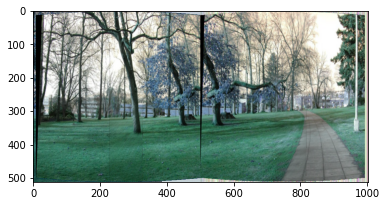

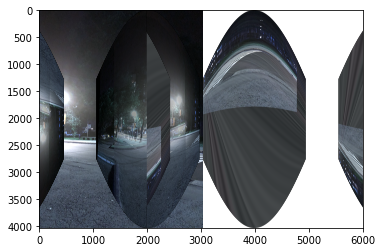

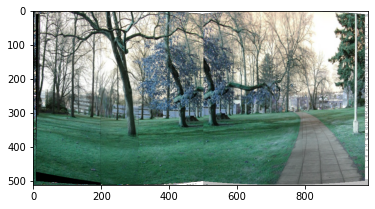

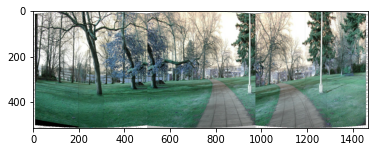

In [733]:
f = open('testfile.txt', 'r')
#dirname = str(f.readline()).strip()
dirname = 'parrington'
while(dirname):   
    array_of_img = [] 
    read_directory(dirname)
    print("dirname", dirname)
    #print( array_of_img)
    array_of_img = array_of_img[:5]
    print("length of image", len(array_of_img))
   
    #break
    imageout = blending(array_of_img)
    cv2.imwrite(dirname+'.jpg', imageout[1])
    plt.figure()
    plt.imshow(imageout[1])
    #cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()
    del array_of_img
    #continue

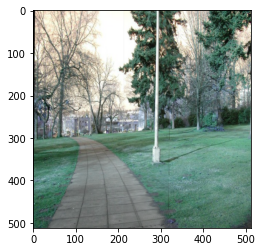